In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

In [22]:
# Load data from SQLite database
query = 'SELECT * FROM red_wine'
conn = sqlite3.connect('Database/wine_database.db')
df = pd.read_sql_query(query, conn)
conn.close()

# Decode special characters
columns_to_decode = ['Name', 'Region', 'Winery']
for col in columns_to_decode:
    df[col] = df[col].str.encode('iso-8859-1').str.decode('utf-8')
   
df = df.drop(columns=['Name'])

# Separate categorical and numerical features
categorical_cols = ['Country', 'Region', 'Winery']
numerical_cols = ['Price', 'Year']

X = df[categorical_cols + numerical_cols]
y = df['Rating']
X

,Country,Region,Winery,Price,Year
0,France,Pomerol,Château La Providence,95.00,2011
1,France,Lirac,Château Mont-Redon,15.50,2017
2,Italy,Toscana,Renzo Masi,7.45,2015
3,Italy,Bardolino,Cavalchina,8.72,2019
4,Austria,Carnuntum,Markowitsch,29.15,2016
...,...,...,...,...,...
8653,United States,Lodi,Michael David Winery,16.47,2016
8654,Italy,Maremma Toscana,Le Mortelle,20.09,2016
8655,France,Haut-Médoc,Château Cambon La Pelouse,23.95,2010
8656,Australia,South Eastern Australia,Yellow Tail,6.21,2019


In [23]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Combine training and test data to fit the encoder
X_combined = pd.concat([X_train, X_test], ignore_index=True)

# Create transformers for preprocessing
cat_transformer = OneHotEncoder(handle_unknown='ignore')
num_transformer = StandardScaler()

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_transformer, categorical_cols),
        ('num', num_transformer, numerical_cols)
    ]
)

# Fit and transform the combined dataset
X_combined_preprocessed = preprocessor.fit_transform(X_combined)

# Split the preprocessed data back into training and test datasets
X_train_preprocessed = X_combined_preprocessed[:len(X_train)]
X_test_preprocessed = X_combined_preprocessed[len(X_train):]

# Create XGBoost model
xgb_model = xgb.XGBRegressor()

# Fit the grid search to the preprocessed training data
xgb_model.fit(X_train_preprocessed, y_train)

# Make predictions on the preprocessed test data
predictions = xgb_model.predict(X_test_preprocessed)

# Calculate R-squared and Mean Squared Error
r2 = r2_score(y_test, predictions)
mse = mean_squared_error(y_test, predictions)

print(f"R-squared: {r2:.4f}")
print(f"Mean Squared Error: {mse:.4f}")

R-squared: 0.6644
Mean Squared Error: 0.0333


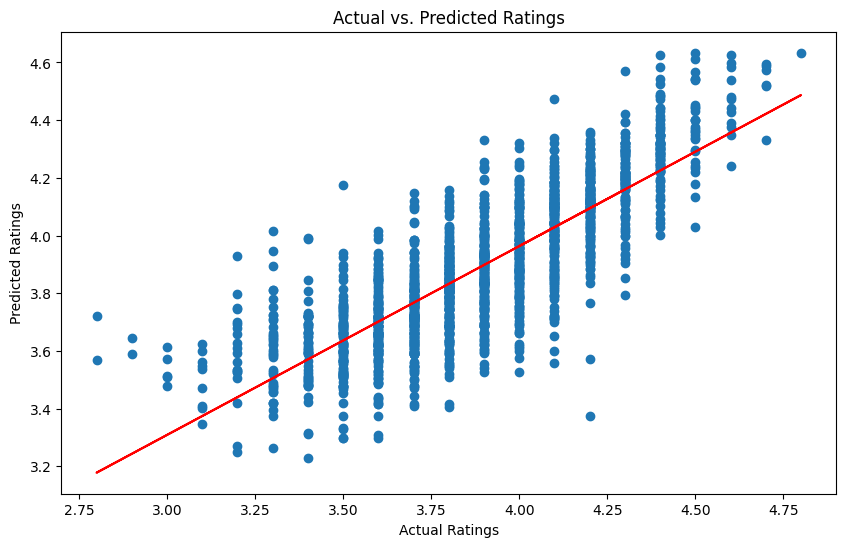

In [24]:
# Plot actual vs. predicted ratings
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions)
slope, intercept = np.polyfit(y_test, predictions, 1)
plt.plot(y_test, slope * y_test + intercept, color='red')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Actual vs. Predicted Ratings')
plt.show()

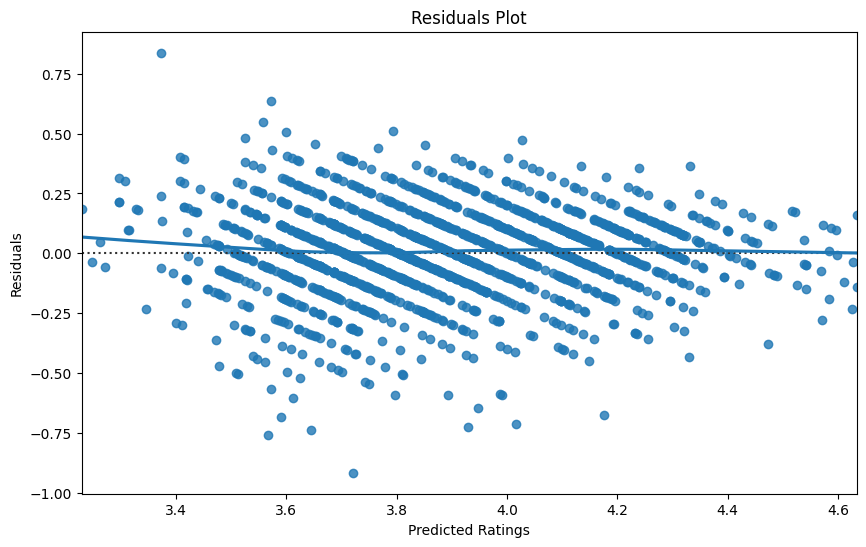

In [25]:
# Plot residuals
residuals = y_test - predictions
plt.figure(figsize=(10, 6))
sns.residplot(x=predictions, y=residuals, lowess=True)
plt.xlabel('Predicted Ratings')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()